# Swing States Correlations Analysis

> In God We Trust. All others must bring data.
> -W. Edwards Deming

US presidential elections are decided by the [Electoral College](https://en.wikipedia.org/wiki/United_States_Electoral_College). Swing states' influence over elections is disproportionate to their populations because of the Electoral College & the US's ([mostly](https://www.270towin.com/content/split-electoral-votes-maine-and-nebraska/)) winner-take-all electoral system.

In the 2024 election, seven states are widely regarded as swing states:
- Arizona
- Georgia
- Michigan
- Wisconsin
- North Carolina
- Pennsylvania
- Nevada

Polling averages as of October 18, 2024 indicate that the two candidates are **statistically tied** in these seven states. Additionally, Nebraska's second congressional district is closely divided and could swing the election [in some scenarios](https://www.ft.com/content/714f8c07-3b2f-4862-bdf2-6878ac8c42ca).

Media outlets are rife with speculation about the different possible electoral maps. For example, *The Financial Times* writes:


> But in mathematical terms, there are scores of other pathways to winning the necessary votes in the electoral college, with and without Pennsylvania.
> For example, either candidate could shore up support in the southern swing states, and Harris would score a big win if she could flip North Carolina — a long-standing Democratic target that Trump won by a razor-thin margin in 2016 — and its 16 electoral college votes back to the Democrats’ column.
> Here is one way to enumerate the routes: **there are 128 combinations of possible outcomes in the seven swing states (two candidates to the seventh power)** where polls suggest the races are in effect tied.

While the FT's basic math is correct, the $2^7$ possible outcomes **are not equally likely.** 

If they were equally likely, we'd have to believe that:
1. the probability of Donald Trump or Kamala Harris winning each state is 50%
2. the outcomes are independent of each other

Polling supports proposition #1, but does not address claim #2.

Anecdotally, recent history suggests swing state outcomes may not be independent of each other. Prior to 2016, Wisconsin, Michigan, and Pennsylvania formed part of the so-called Blue Wall of reliably Democratic Midwestern states. In 2016, these states moved *together* into Donald Trump's column; in 2020, they again moved together into Joe Biden's. 

I was interested in checking whether this anecdotal evidence holds up more rigorously, so I accessed data on US presidential elections since 1976 to investigate quantitatively **how strongly swing state outcomes move together** – statisticians and data scientists call this covariance.

## Hypothesis Pre-registration

Recently statisticians and other quantitative researchers have moved towards a norm of pre-registering hypotheses. This is intended to prevent cherry-picking data. To contribute to this norm, I am writing my hypotheses in this notebook BEFORE any analysis. Readers can verify this by referencing the GitHub commit history and examining the "pre-registering hypotheses" commit.

Hypotheses:
1. The presidential election outcome in each swing state are is moderately correlated ($R^2 > 0.3$) with at least one other swing state.
2. Swing state correlations have increased over time, as evidenced by an increase in the moving average correlation coefficient.
3. Wisconsin, Michigan, and Pennsylvania are more highly correlated with each other than with other swing states.

## Data Import and Preparation

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
import plotly.express as px
import numpy as np
import itertools

In [183]:
IN_SCOPE_PARTIES = {"DEMOCRAT", "REPUBLICAN"}
SWING_STATES = {"ARIZONA", "WISCONSIN", "MICHIGAN", "PENNSYLVANIA", "NEVADA", "NORTH CAROLINA", "GEORGIA"}

In [184]:
data_path = "../data/us_elections_1976-2020.csv"

raw_df = pd.read_csv(data_path)

raw_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


In [185]:
print("\n".join(list(raw_df.columns)))

year
state
state_po
state_fips
state_cen
state_ic
office
candidate
party_detailed
writein
candidatevotes
totalvotes
version
notes
party_simplified


In [186]:
set(raw_df["office"])

{'US PRESIDENT'}

In [187]:
compact_df = raw_df[["year",
                     "state",
                     "candidate",
                     "candidatevotes",
                     "totalvotes",
                     "party_detailed",
                     "party_simplified"]]

compact_df.head()

,year,state,candidate,candidatevotes,totalvotes,party_detailed,party_simplified
0,1976,ALABAMA,"CARTER, JIMMY",659170,1182850,DEMOCRAT,DEMOCRAT
1,1976,ALABAMA,"FORD, GERALD",504070,1182850,REPUBLICAN,REPUBLICAN
2,1976,ALABAMA,"MADDOX, LESTER",9198,1182850,AMERICAN INDEPENDENT PARTY,OTHER
3,1976,ALABAMA,"BUBAR, BENJAMIN """"BEN""""",6669,1182850,PROHIBITION,OTHER
4,1976,ALABAMA,"HALL, GUS",1954,1182850,COMMUNIST PARTY USE,OTHER


In [188]:
major_parties_df = compact_df[compact_df["party_detailed"].isin(IN_SCOPE_PARTIES)]

major_parties_df.head()

,year,state,candidate,candidatevotes,totalvotes,party_detailed,party_simplified
0,1976,ALABAMA,"CARTER, JIMMY",659170,1182850,DEMOCRAT,DEMOCRAT
1,1976,ALABAMA,"FORD, GERALD",504070,1182850,REPUBLICAN,REPUBLICAN
7,1976,ALASKA,"FORD, GERALD",71555,123574,REPUBLICAN,REPUBLICAN
8,1976,ALASKA,"CARTER, JIMMY",44058,123574,DEMOCRAT,DEMOCRAT
11,1976,ARIZONA,"FORD, GERALD",418642,742719,REPUBLICAN,REPUBLICAN


In [189]:
swing_state_df = major_parties_df[major_parties_df["state"].isin(SWING_STATES)]
swing_state_df.head()

,year,state,candidate,candidatevotes,totalvotes,party_detailed,party_simplified
11,1976,ARIZONA,"FORD, GERALD",418642,742719,REPUBLICAN,REPUBLICAN
12,1976,ARIZONA,"CARTER, JIMMY",295602,742719,DEMOCRAT,DEMOCRAT
60,1976,GEORGIA,"CARTER, JIMMY",979409,1463152,DEMOCRAT,DEMOCRAT
61,1976,GEORGIA,"FORD, GERALD",483743,1463152,REPUBLICAN,REPUBLICAN
133,1976,MICHIGAN,"FORD, GERALD",1893742,3651590,REPUBLICAN,REPUBLICAN


In [190]:
swing_state_df.loc[:,"vote_pct"] = swing_state_df["candidatevotes"] / swing_state_df["totalvotes"]
swing_state_df.head()

/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_12541/1946419442.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swing_state_df.loc[:,"vote_pct"] = swing_state_df["candidatevotes"] / swing_state_df["totalvotes"]


,year,state,candidate,candidatevotes,totalvotes,party_detailed,party_simplified,vote_pct
11,1976,ARIZONA,"FORD, GERALD",418642,742719,REPUBLICAN,REPUBLICAN,0.563661
12,1976,ARIZONA,"CARTER, JIMMY",295602,742719,DEMOCRAT,DEMOCRAT,0.398000
60,1976,GEORGIA,"CARTER, JIMMY",979409,1463152,DEMOCRAT,DEMOCRAT,0.669383
61,1976,GEORGIA,"FORD, GERALD",483743,1463152,REPUBLICAN,REPUBLICAN,0.330617
133,1976,MICHIGAN,"FORD, GERALD",1893742,3651590,REPUBLICAN,REPUBLICAN,0.518608


In [191]:
pivoted_df = swing_state_df.pivot(index=["year", "state", "candidate"], columns = ["party_detailed"], values="vote_pct")

In [192]:
party_share_df = pivoted_df.groupby(["year", "state"]).agg("sum")

PCT_ADJ = 100

# REBASE TO ENSURE D + R = 100

party_share_df["DEMOCRAT"] = party_share_df["DEMOCRAT"] / (party_share_df["DEMOCRAT"] + party_share_df["REPUBLICAN"])
party_share_df["REPUBLICAN"] = party_share_df["REPUBLICAN"] / (party_share_df["DEMOCRAT"] + party_share_df["REPUBLICAN"])

party_share_df["DEMOCRAT"] = round(party_share_df["DEMOCRAT"] * PCT_ADJ,2) # clean up formatting
party_share_df["REPUBLICAN"] = round(party_share_df["REPUBLICAN"] * PCT_ADJ,2)

party_share_df

party_detailed       DEMOCRAT  REPUBLICAN
year state                               
1976 ARIZONA            41.39       57.66
     GEORGIA            66.94       33.06
     MICHIGAN           47.26       52.32
     NEVADA             47.73       51.24
     NORTH CAROLINA     55.55       44.32
...                       ...         ...
2020 MICHIGAN           51.41       48.20
     NEVADA             51.22       48.20
     NORTH CAROLINA     49.32       50.31
     PENNSYLVANIA       50.59       49.12
     WISCONSIN          50.32       49.25

[84 rows x 2 columns]

## Analysis

First, I put together a simple visualization of the rebased vote shares for Demcrats and Republicans in each swing state since 1976. The code for this visualization is below if you're interested, but you can **skip straight to Fig 1** to just see the result.

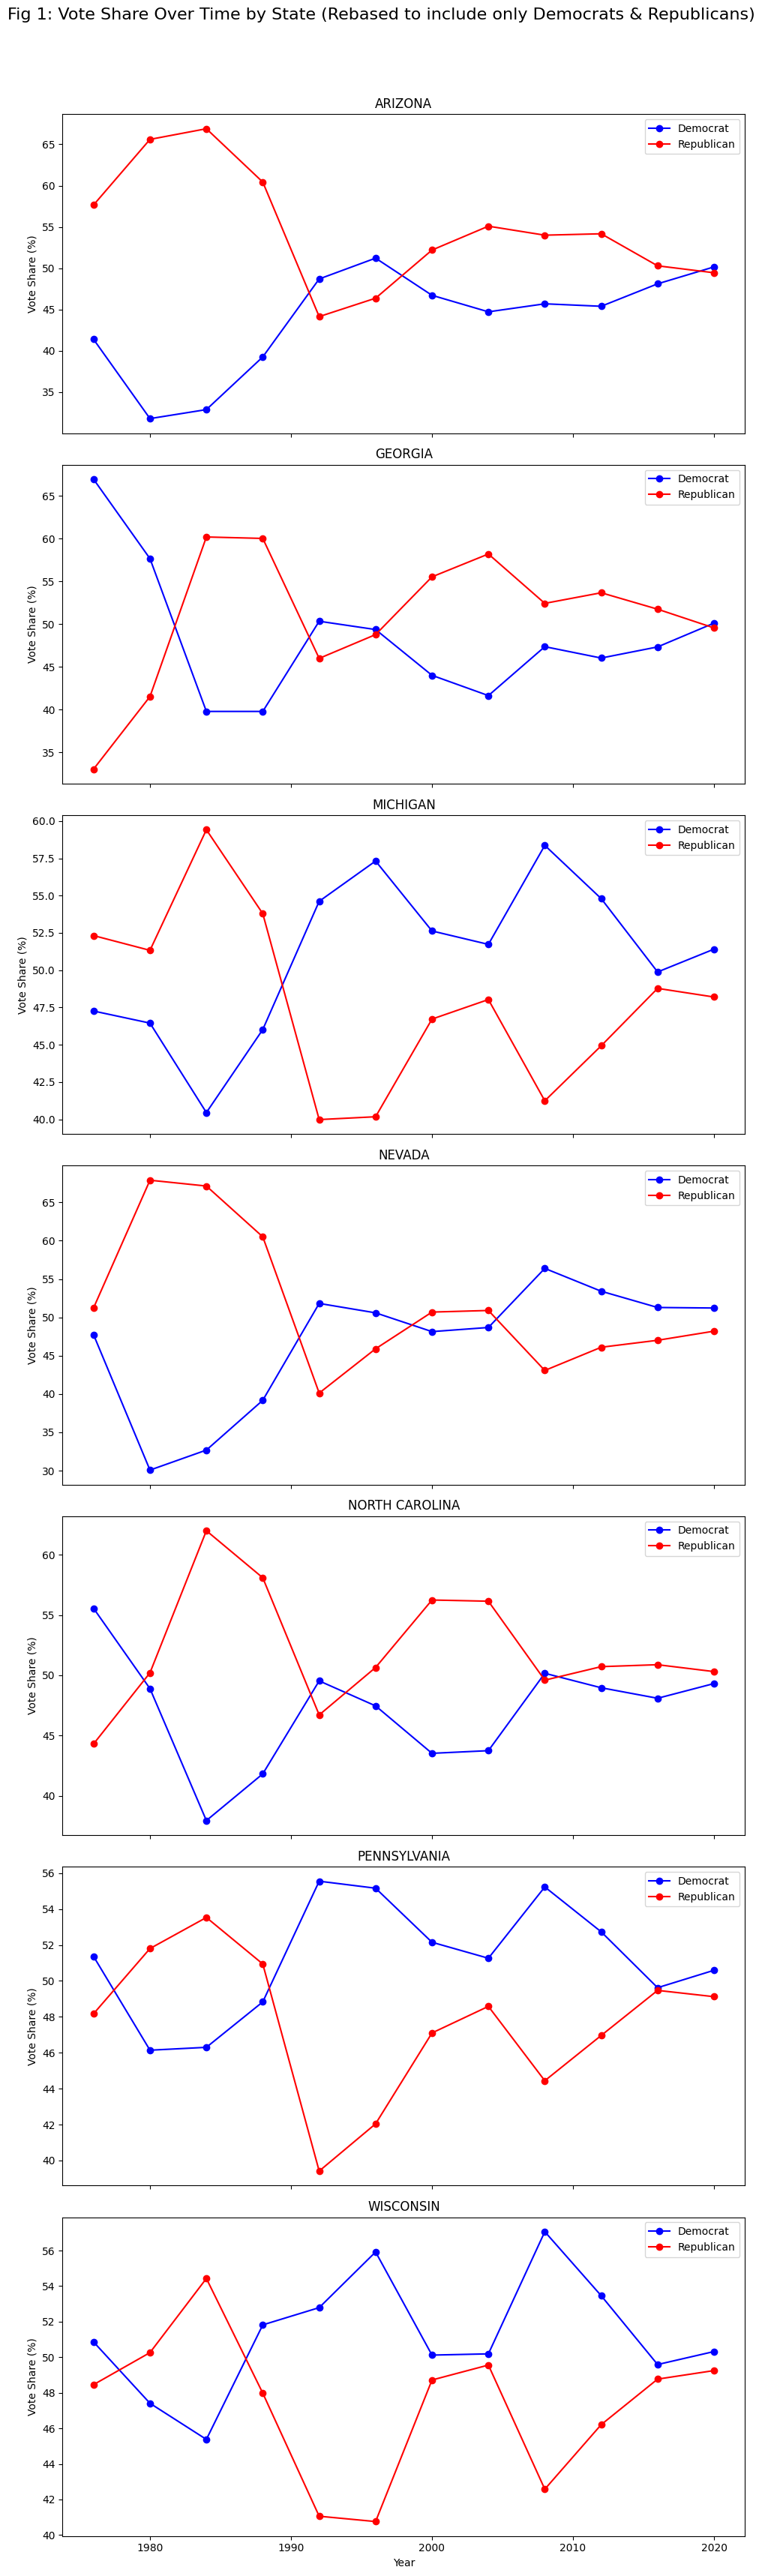

In [193]:
# Reset index
df = party_share_df.reset_index()

# Create subplots
states = df['state'].unique()
fig, axes = plt.subplots(nrows=len(states), ncols=1, sharex=True, figsize=(10, 5 * len(states)))

# Add traces for each state
for i, state in enumerate(states):
    state_data = df[df['state'] == state]
    
    # Plot Democrat trace
    axes[i].plot(state_data['year'], state_data['DEMOCRAT'], 
                 marker='o', color='blue', label='Democrat')
    
    # Plot Republican trace
    axes[i].plot(state_data['year'], state_data['REPUBLICAN'], 
                 marker='o', color='red', label='Republican')
    
    # Set title for each subplot
    axes[i].set_title(state)
    axes[i].set_ylabel('Vote Share (%)')
    axes[i].legend()  # Show legend

# Update layout
plt.xlabel('Year')
plt.suptitle('Fig 1: Vote Share Over Time by State (Rebased to include only Democrats & Republicans)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle

# Show the figure
plt.show()

Visually, we can see that many states seem to move up and down together.

But let's quantify this rigorously by calculating correlations below. If you're interested in code, keep reading. **To skip to results, see Fig 2.**

In [194]:
dem_df = party_share_df.reset_index().loc[:, ["year", "state", "DEMOCRAT"]]

state_dem_df = dem_df.pivot(index = ["year"], columns="state", values="DEMOCRAT")

state_dem_df

state,ARIZONA,GEORGIA,MICHIGAN,NEVADA,NORTH CAROLINA,PENNSYLVANIA,WISCONSIN
year,,,,,,,
1976,41.39,66.94,47.26,47.73,55.55,51.36,50.86
1980,31.79,57.66,46.45,30.07,48.90,46.14,47.41
1984,32.88,39.80,40.45,32.68,37.97,46.30,45.38
1988,39.26,39.80,46.02,39.18,41.84,48.83,51.82
1992,48.70,50.34,54.62,51.82,49.54,55.55,52.79
1996,51.22,49.37,57.32,50.59,47.47,55.16,55.92
2000,46.72,44.02,52.63,48.14,43.54,52.15,50.12
2004,44.72,41.65,51.73,48.68,43.76,51.26,50.19
2008,45.69,47.37,58.37,56.39,50.17,55.23,57.06


In [195]:
correlation_matrix = state_dem_df.corr()
rounded_corr = correlation_matrix.round(2)

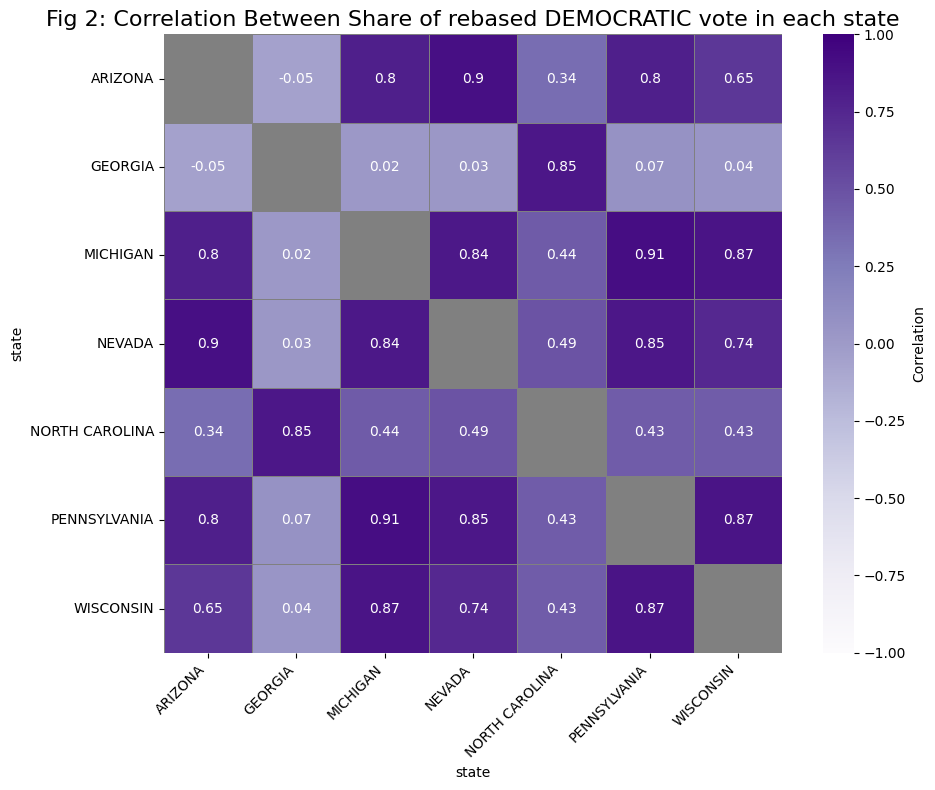

In [196]:
# Create a correlation matrix
rounded_corr = state_dem_df.corr().round(2)

# Create a mask for the diagonal
diagonal_mask = np.eye(rounded_corr.shape[0], dtype=bool)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(rounded_corr, annot=True, cmap='Purples', 
            vmin=-1, vmax=1, square=True, cbar_kws={"label": "Correlation"},
            linewidths=.5, linecolor='gray', mask=diagonal_mask)

# Update layout
plt.title('Fig 2: Correlation Between Share of rebased DEMOCRATIC vote in each state', fontsize=16)
plt.xticks(ticks=np.arange(rounded_corr.shape[0]) + 0.5, 
           labels=rounded_corr.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(rounded_corr.shape[0]) + 0.5, 
           labels=rounded_corr.columns, rotation=0)
plt.gca().set_facecolor('gray')  # Set the background to white
plt.gca().xaxis.grid(False)  # Remove grid lines from the x-axis
plt.gca().yaxis.grid(False)  # Remove grid lines from the y-axis

# Show the figure
plt.tight_layout()
plt.show()

This shows convincingly that since 1976, the share of Democratic votes between swing states are **highly correlated with each other, not independent**. Because third-party candidates are insignificant in most elections, I would get an almost identical table if I plotted the correlation between Republican votes across swing states. 

Let's dig deeper to see which states are the most correlated with others and which are more independent of other states. Visually, Arizona and the Blue Wall states seem have a lot of high correlations <span style="color: purple;"><b>(dark purple)</b></span> while Georgia and North Carolina have lower correlations with other states. We can quantify this to be sure:

In [197]:
rounded_corr.mean().sort_values()

state
GEORGIA           0.280000
NORTH CAROLINA    0.568571
ARIZONA           0.634286
WISCONSIN         0.657143
NEVADA            0.692857
MICHIGAN          0.697143
PENNSYLVANIA      0.704286
dtype: float64

Surprisingly (from the perspective of my initial hypothesis) Nevada's Democratic vote share is the most highly correlated, on average, with other states'. Georgia's is by far the lowest between 1976 and 2020. 

As expected, each of the Blue Wall states have Democratic vote shares that are **highly correlated with each other**. 

Critically, this allows us to make a conclusion: if historical results are any indication of how the 2024 election might turn out, scenarios in which a candidate wins one Blue Wall state but not another are presumptively unlikely.

To illustrate this, below I simulate 100 hypothetical elections in Pennsylvania and Wisconsin. I take the (rebased) mean and standard deviation of the vote share for Democrats since 1976, model the percentage of voters choosing Democrats as roughly normally distributed, and **model Pennsylvania and Wisconsin's using the correlation I found above.**

See Fig 3 below for the outcome.

In [198]:
sum_stats = state_dem_df.describe()

In [199]:
def simulate_election(state_1, state_2, fig_num):
    
    # Set the seed for reproducibility
    np.random.seed(0)

    num_samples = 100
    mean = [sum_stats.loc["mean", state_1], sum_stats.loc["mean", state_2]]  # Mean for both variables
    covariance_matrix = [[1, rounded_corr.loc[state_1, state_2]],  # Variance of the first variable and correlation with the second
                        [rounded_corr.loc[state_1, state_2], 1]]  # Variance of the second variable and correlation with the first

    # Generate correlated normal variables
    samples = np.random.multivariate_normal(mean, covariance_matrix, num_samples)

    # Create a DataFrame for convenience
    df = pd.DataFrame(samples, columns=[state_1[:2], state_2[:2]])  # Use the first two letters of state names for columns

    # Plot the results
    plt.figure(figsize=(8, 6))

    plt.title(f'Fig {fig_num}: Simulated Election Outcomes in {state_1} and {state_2}, based on 1976-2020 outcomes')
    plt.xlabel(f'Simulated % of Democratic Vote in {state_1}')
    plt.ylabel(f'Simulated % of Democratic Vote in {state_2}')
    plt.axhline(0, color='gray', lw=1, linestyle='--')
    plt.axvline(0, color='gray', lw=1, linestyle='--')
    plt.grid(False)

    # Adjust axes limits to fit the data
    plt.xlim(df[state_1[:2]].min() - 1, df[state_1[:2]].max() + 1)  # Adjust x limits
    plt.ylim(df[state_2[:2]].min() - 1, df[state_2[:2]].max() + 1)  # Adjust y limits

    # Shade the area to the right of x = 50
    plt.fill_betweenx(plt.ylim(), 50, plt.xlim()[1], color='blue', alpha=0.2)
    # Shade the area above y = 50
    plt.fill_between(plt.xlim(), 50, plt.ylim()[1], color='blue', alpha=0.2)

    plt.scatter(df[state_1[:2]], df[state_2[:2]], color="purple", edgecolors="black")
    plt.text(df[state_1[:2]].min(), 51, f'Democrats Win \n{state_2}')
    plt.text(52, df[state_2[:2]].min(), f"Democrats Win \n{state_1}")
    plt.text(df[state_1[:2]].max()-0.5, df[state_2[:2]].max()-0.5, "Democrats \nWin \nBOTH STATES")

    plt.show()


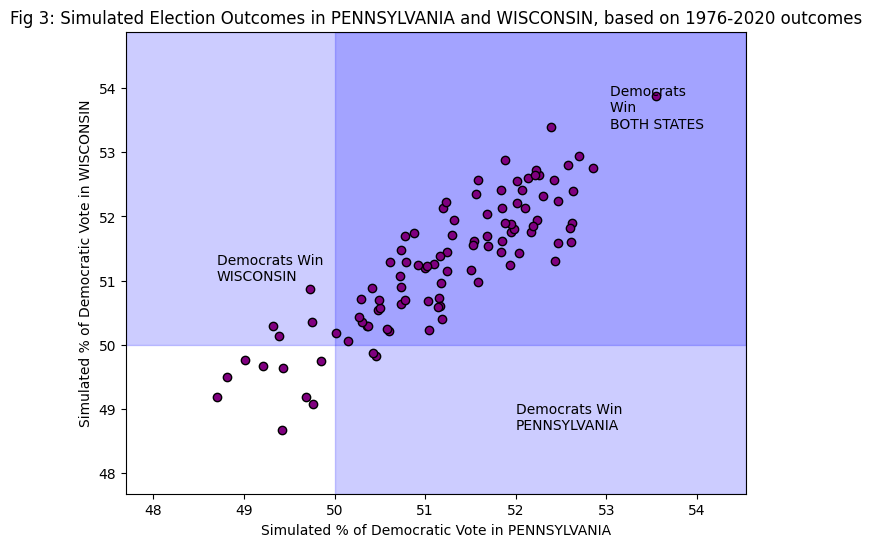

In [200]:
simulate_election("PENNSYLVANIA", "WISCONSIN", 3)

Notice that there are a lot more simulated outcomes where Democrats win (or lose) both states than where they win one or the other!

Note: this **is not** a forecast. I am not suggesting that historical data is predictive of the 2024 outcome. The more important thing is that, historically, these states **MOVE TOGETHER.** So we should be skeptical when pundits talk about paths to winning the Electoral College where, for example, Kamala Harris wins Pennsylvania but loses Wisconsin. This is historically unlikely.

On the other hand, it's much likelier that Democrats win Pennsylvania but lose Georgia, because these states' outcomes aren't highly correlated:

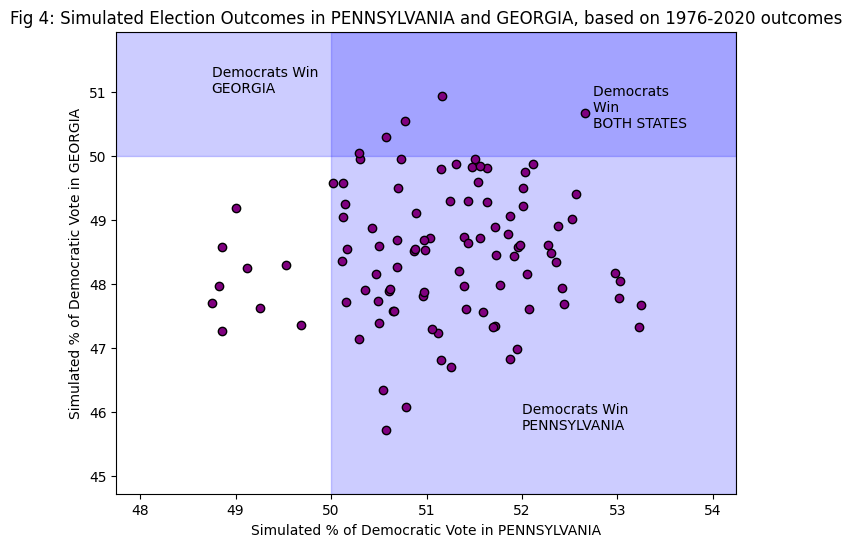

In [201]:
simulate_election("PENNSYLVANIA", "GEORGIA", 4)

Finally, let's look at how this has moved over time. To do this, I calculate the 3-election moving correlation between the different states.

In [202]:
def get_rolling_correlation(state_1, state_2, window = 3):

    rolling_corr = state_dem_df[state_1].rolling(window=window).corr(state_dem_df[state_2])
    return rolling_corr

def plot_rolling_corr(rolling_corr, state_1, state_2, window=3, fig_num=5):
    plt.figure(figsize=(10, 6))
    plt.plot(rolling_corr, label=f'Rolling Correlation ({window}-Record)', color='blue')
    plt.title(f'Fig {fig_num}: Rolling Correlation between {state_1} and {state_2}')
    plt.xlabel('Year')
    plt.ylabel('Correlation')
    plt.axhline(0, color='gray', linestyle='--', lw=1)
    plt.axvline(0, color='gray', linestyle='--', lw=1)
    # Set x and y limits to fit the data
    plt.xlim(rolling_corr.index.min(), rolling_corr.index.max())  # Adjust x limits to match the index range
    plt.ylim(rolling_corr.min() - 0.1, rolling_corr.max() + 0.1)  # Adjust y limits slightly beyond the min/max correlation
    plt.grid()
    plt.legend()
    plt.show()

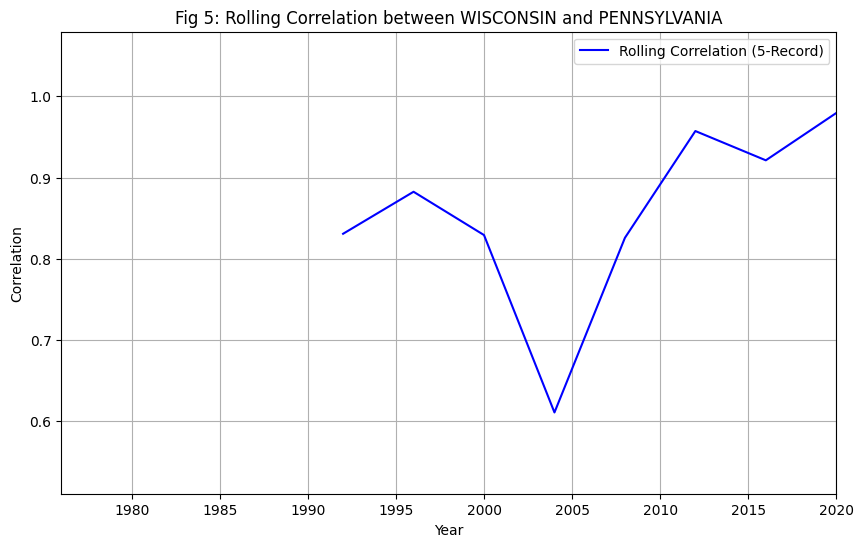

In [203]:
plot_rolling_corr(get_rolling_correlation("WISCONSIN", "PENNSYLVANIA", 5), "WISCONSIN", "PENNSYLVANIA", 5, 5)

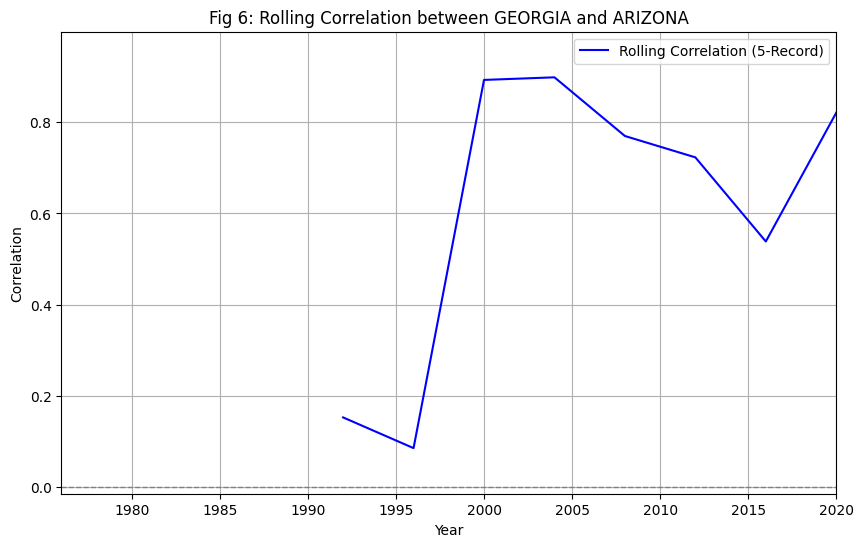

In [204]:
plot_rolling_corr(get_rolling_correlation("GEORGIA", "ARIZONA", 5), "GEORGIA", "ARIZONA", 5, 6)

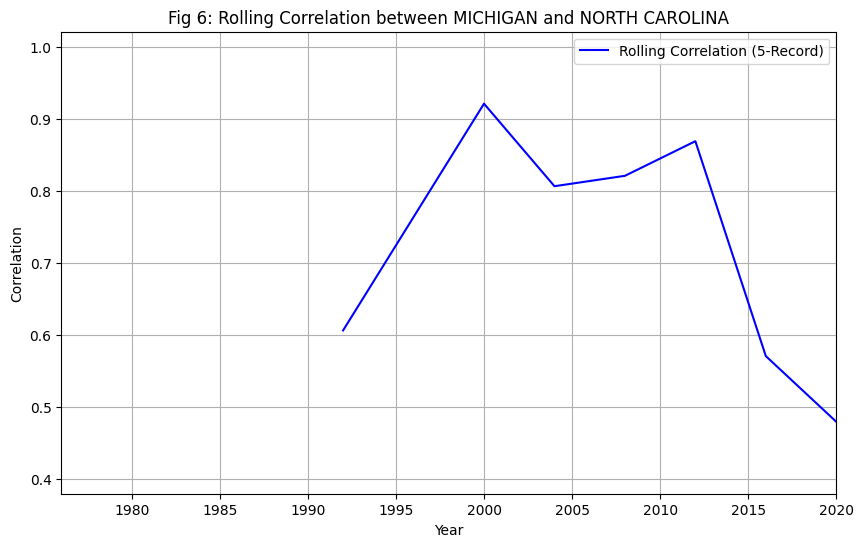

In [205]:
plot_rolling_corr(get_rolling_correlation("MICHIGAN", "NORTH CAROLINA", 5), "MICHIGAN", "NORTH CAROLINA", 5, 6)

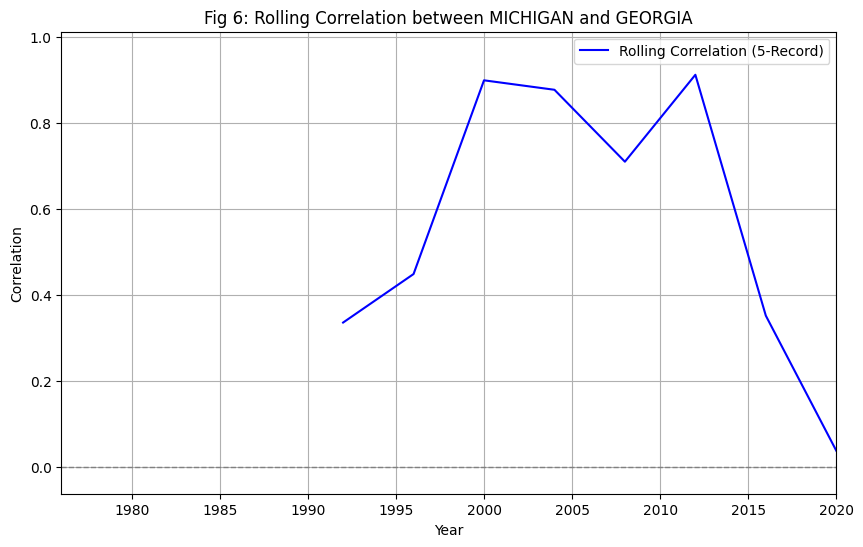

In [206]:
plot_rolling_corr(get_rolling_correlation("MICHIGAN", "GEORGIA", 5), "MICHIGAN", "GEORGIA", 5, 6)

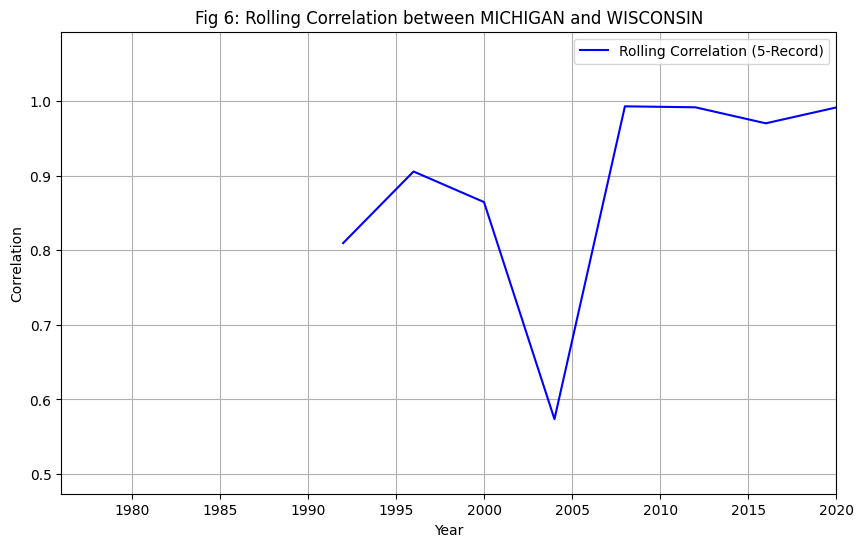

In [207]:
plot_rolling_corr(get_rolling_correlation("MICHIGAN", "WISCONSIN", 5), "MICHIGAN", "WISCONSIN", 5, 6)

To do this systematically:

In [208]:
# Initialize a DataFrame to store results
results_matrix = pd.DataFrame(index=list(SWING_STATES), columns=list(SWING_STATES), dtype=int)


# Iterate over every unique combination of states
for state_1, state_2 in itertools.combinations(list(SWING_STATES), 2):
    # Get the rolling correlation for the state pair
    rolling_corr = list(get_rolling_correlation(state_1, state_2).dropna())

    # Check if the rolling correlation increased over time
    increased = rolling_corr[-1] > rolling_corr[0]  # Compare the last and first values

    # Record the result in the matrix
    results_matrix.loc[state_1, state_2] = 1 if increased else 0
    results_matrix.loc[state_2, state_1] = 1 if increased else 0  # Fill the symmetrical entry

# Display the results matrix
print(results_matrix)

                PENNSYLVANIA  GEORGIA  ARIZONA  MICHIGAN  WISCONSIN  NEVADA  \
PENNSYLVANIA             NaN      0.0      0.0       1.0        1.0     0.0   
GEORGIA                  0.0      NaN      1.0       0.0        0.0     0.0   
ARIZONA                  0.0      1.0      NaN       0.0        0.0     0.0   
MICHIGAN                 1.0      0.0      0.0       NaN        1.0     1.0   
WISCONSIN                1.0      0.0      0.0       1.0        NaN     1.0   
NEVADA                   0.0      0.0      0.0       1.0        1.0     NaN   
NORTH CAROLINA           0.0      0.0      0.0       0.0        0.0     0.0   

                NORTH CAROLINA  
PENNSYLVANIA               0.0  
GEORGIA                    0.0  
ARIZONA                    0.0  
MICHIGAN                   0.0  
WISCONSIN                  0.0  
NEVADA                     0.0  
NORTH CAROLINA             NaN  


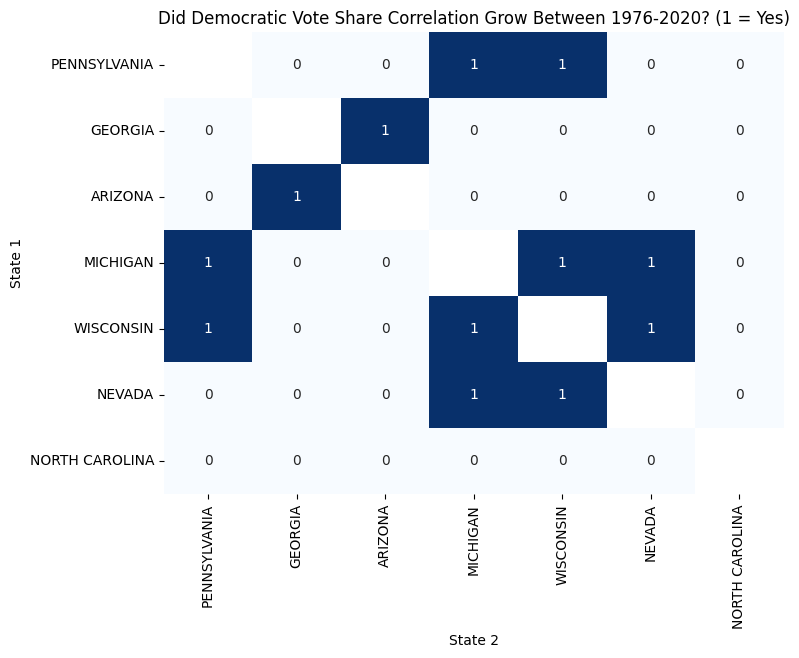

In [209]:
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(results_matrix, annot=True, cmap='Blues', cbar=False)

# Add title and labels
plt.title('Did Democratic Vote Share Correlation Grow Between 1976-2020? (1 = Yes)')
plt.xlabel('State 2')
plt.ylabel('State 1')

# Show the plot
plt.show()